In [2]:
import tensorflow
from PIL import Image
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, save_img, img_to_array
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization,Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from sklearn.metrics import classification_report,accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import numpy as np 
from tqdm import tqdm
from sklearn.utils import shuffle
import cv2
import os
import shutil
import itertools
import imutils
from sklearn.model_selection import StratifiedKFold
import random
from tensorflow.keras import layers

     

In [3]:
import os
import numpy as np
import cv2
from tqdm import tqdm

# Labels
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Define dataset paths 
BASE_DIR = r"C:\Users\akanv\Downloads\dataset\dataset\cropped"
TRAINING_DIR = os.path.join(BASE_DIR, "Training")
TESTING_DIR = os.path.join(BASE_DIR, "Testing")

# Lists for storing images and labels
x_train, y_train = [], []
x_test, y_test = [], []

image_size = 200  # Resize images to this size

# ✅ **Process training and testing images**
for label_index, label in enumerate(labels):
    trainPath = os.path.join(TRAINING_DIR, label)
    testPath = os.path.join(TESTING_DIR, label)

    # Ensure the directory exists
    if not os.path.exists(trainPath) or not os.path.exists(testPath):
        print(f"Warning: Directory {trainPath} or {testPath} not found!")
        continue

    print(f"\n Processing label: {label.upper()}")

    # Load training images
    for file in tqdm(os.listdir(trainPath), desc=f"Processing {label} (Train)"):
        image_path = os.path.join(trainPath, file)
        image = cv2.imread(image_path, 0)  # Load in grayscale
        if image is None:
            print(f" Skipped {file} (Corrupt file)")
            continue  # Skip corrupt files

        image = cv2.bilateralFilter(image, 2, 50, 50)  # Noise reduction
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)  # Pseudocoloring
        image = cv2.resize(image, (image_size, image_size))  # Resize
        x_train.append(image)
        y_train.append(label_index)  # Append correct label index

    # Load testing images
    for file in tqdm(os.listdir(testPath), desc=f"Processing {label} (Test)"):
        image_path = os.path.join(testPath, file)
        image = cv2.imread(image_path, 0)
        if image is None:
            print(f" Skipped {file} (Corrupt file)")
            continue  # Skip corrupt files

        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(label_index)  # Append correct label index

# ✅ **Convert images to NumPy arrays and normalize**
x_train = np.array(x_train, dtype=np.uint8)  # Efficient memory usage
x_test = np.array(x_test, dtype=np.uint8)

x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0


y_train = np.array(y_train, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)


print("\nFinal Data Shapes:")
print(f" x_train.shape: {x_train.shape}")
print(f"✅ y_train.shape: {y_train.shape}")  
print(f"✅ x_test.shape: {x_test.shape}")
print(f"✅ y_test.shape: {y_test.shape}")

# ✅ **Check if x_train and y_train match**
if len(x_train) == len(y_train):
    print("✅ x_train and y_train sizes match!")
else:
    print(f"❌ Mismatch found: x_train={len(x_train)}, y_train={len(y_train)}")



 Processing label: GLIOMA


Processing glioma (Test): 100%|██████████████████████████████████████████████████████| 300/300 [00:04<00:00, 74.26it/s]



 Processing label: MENINGIOMA


Processing meningioma (Test): 100%|██████████████████████████████████████████████████| 306/306 [00:06<00:00, 45.03it/s]



 Processing label: NOTUMOR


Processing notumor (Test): 100%|█████████████████████████████████████████████████████| 405/405 [00:06<00:00, 59.65it/s]



 Processing label: PITUITARY


Processing pituitary (Test): 100%|███████████████████████████████████████████████████| 300/300 [00:04<00:00, 65.38it/s]



Final Data Shapes:
 x_train.shape: (5712, 200, 200, 3)
✅ y_train.shape: (5712,)
✅ x_test.shape: (1311, 200, 200, 3)
✅ y_test.shape: (1311,)
✅ x_train and y_train sizes match!


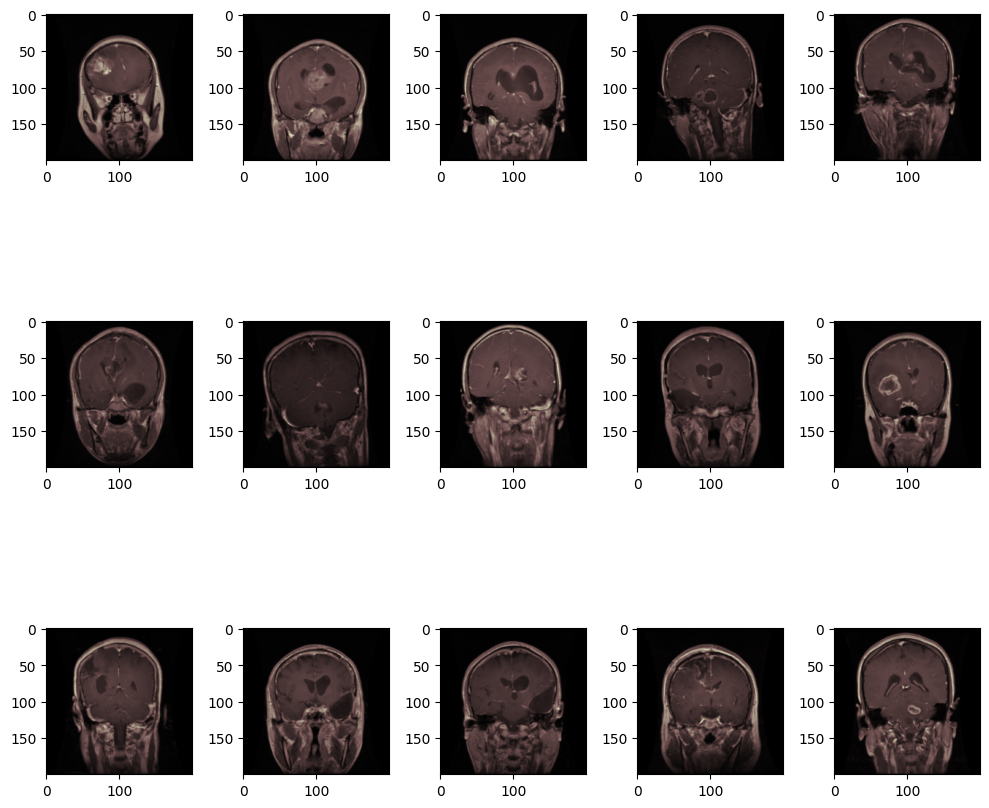

In [4]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()


In [5]:
x_train, y_train = shuffle(x_train,y_train, random_state=42) 

y_train = tensorflow.keras.utils.to_categorical(y_train) #One Hot Encoding on the labels
y_test = tensorflow.keras.utils.to_categorical(y_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42) #Dividing the dataset into Training and Validation sets.

print(x_val.shape)
     

(1143, 200, 200, 3)


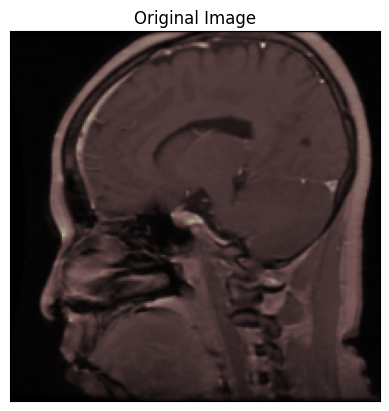

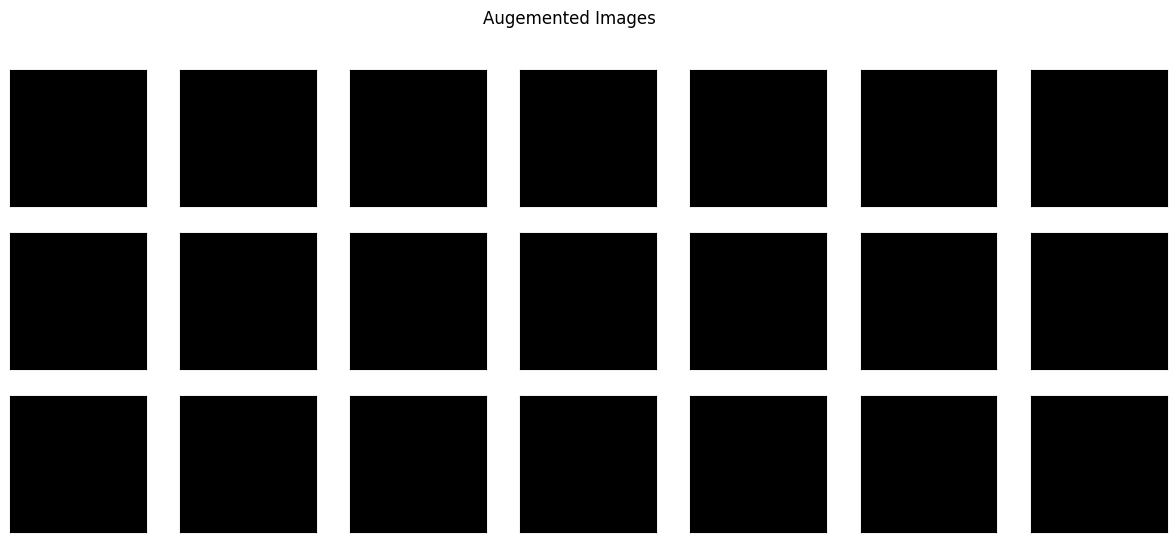

In [6]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)


os.mkdir('preview_15')
x = x_train[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview_15', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 
     

plt.imshow(x[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview_15/'):
    img = cv2.imread('preview_15/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [7]:
# ImageDataGenerator transforms each image in the batch by a series of random translations, rotations, etc.
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    zoom_range=0.2,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

# After you have created and configured your ImageDataGenerator, you must fit it on your data.
datagen.fit(x_train)

In [8]:
import numpy as np
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define the input size and ResNet50 base model
IMG_SIZE = (200, 200)
conv_base = ResNet50(
    include_top=False,  # Exclude the fully connected layers at the top
    input_shape=IMG_SIZE + (3,),  # Input shape: (200, 200, 3)
    weights='imagenet'  # Use pre-trained weights from ImageNet
)

# Set all layers in ResNet50 to be trainable (fine-tuning)
for layer in conv_base.layers:
    layer.trainable = True

# Add custom layers on top of ResNet50
x = conv_base.output  # Use the output of ResNet50
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dropout(0.4)(x)  # Dropout for regularization
output = Dense(4, activation="softmax")(x)  # Output layer for 4 classes

# Define the final model
model = Model(inputs=conv_base.input, outputs=output)

# Reshape or reformat the labels
y_train = y_train.reshape(y_train.shape[0], -1)  # Flatten extra dimensions
y_val = y_val.reshape(y_val.shape[0], -1)  # Flatten extra dimensions

# Keep only the first 4 columns (if needed)
y_train = y_train[:, :4]  # Reshape to (2924, 4)
y_val = y_val[:, :4]  # Reshape to (731, 4)

# Compile the model
adam = Adam(learning_rate=0.0001)  # Adam optimizer with a learning rate of 0.0001
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=10,
    callbacks=callbacks
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 27s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 200, 200, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 206, 206, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 100, 100, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 100, 100, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 100, 100, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 102, 102, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 50, 50, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 50, 50, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 50, 50, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 50, 50, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 50, 50, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 50, 50, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 50, 50, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 50, 50, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 50, 50, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

NameError: name 'callbacks' is not defined

In [9]:
callbacks = [
    ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=1, mode='min', min_lr=0.00000000001)
]


In [10]:

train_len = len(x_train)
val_len = len(x_val)
print("-----------Training Data length-----------------")
print(train_len)

print("-----------Validation Data length-----------------")
print(val_len)
     

-----------Training Data length-----------------
4569
-----------Validation Data length-----------------
1143


In [11]:
y_train = y_train.reshape(y_train.shape[0], -1)  # Reshape to (2924, 16)
y_val = y_val.reshape(y_val.shape[0], -1)  # Reshape to (731, 16)

# Keep only the first 4 columns (if needed)
y_train = y_train[:, :4]  # Reshape to (2924, 4)
y_val = y_val[:, :4]  # Reshape to (731, 4)

In [12]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    validation_data=(x_val, y_val),
    epochs=10,
    callbacks=callbacks
)


C:\Users\akanv\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
18/72 ━━━━━━━━━━━━━━━━━━━━ 2:42:14 180s/step - accuracy: 0.2703 - loss: 1.4870

KeyboardInterrupt: 

In [1]:
import tensorflow as tf

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))


Num GPUs Available: 0
[]
